In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl

import sys
sys.path.insert(0, ".")


# Testing Assumptions

Usually, you will start with empirical data.

You might have educated guesses about the distributions, but you are often not sure.

Let's see how to test this.

## Preprocess
First, we preprocess the penguins data so that we only have the floating point data for continuous distributions

We load the dataset

In [2]:
df = sns.load_dataset("penguins")


Drop missing values

In [3]:
df = df.dropna()


Select target value and floating point values for plotting

In [4]:
target = "species"

targetlocation = np.array([target == c for c in df.columns])
floatingvalues = np.array(df.dtypes == float)

subset = df.iloc[:, targetlocation | floatingvalues]
subset.head()


,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0


And melt everything for easier plotting

In [5]:
p = subset.melt(id_vars="species")
p.head()


,species,variable,value
0,Adelie,bill_length_mm,39.1
1,Adelie,bill_length_mm,39.5
2,Adelie,bill_length_mm,40.3
3,Adelie,bill_length_mm,36.7
4,Adelie,bill_length_mm,39.3


To make the plotting easier, we normalize all variables

In [6]:
p["norm"] = p.groupby("variable", group_keys=False)["value"].apply(
    lambda x: (x - x.mean()) / x.std()
)

p.head()


,species,variable,value,norm
0,Adelie,bill_length_mm,39.1,-0.894695
1,Adelie,bill_length_mm,39.5,-0.821552
2,Adelie,bill_length_mm,40.3,-0.675264
3,Adelie,bill_length_mm,36.7,-1.333559
4,Adelie,bill_length_mm,39.3,-0.858123


Now, we have melted and normalized data.


## Visualize

<AxesSubplot: xlabel='variable', ylabel='norm'>

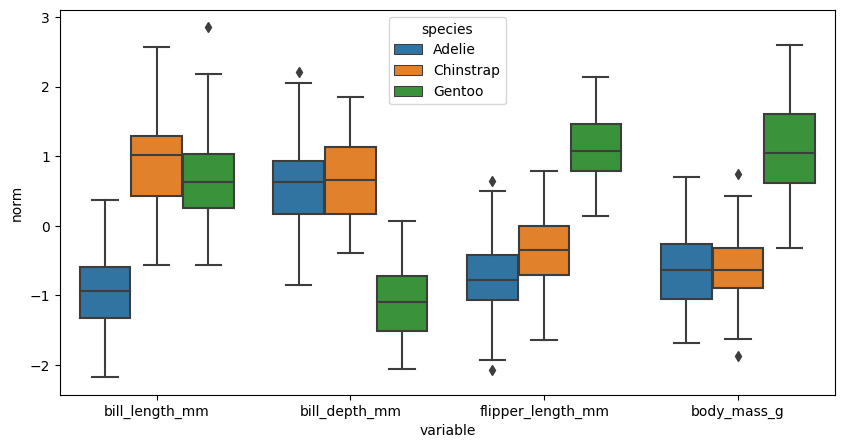

In [7]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=p, x="variable", y="norm", hue="species")


Are this normal distributions?

<AxesSubplot: xlabel='norm', ylabel='Density'>

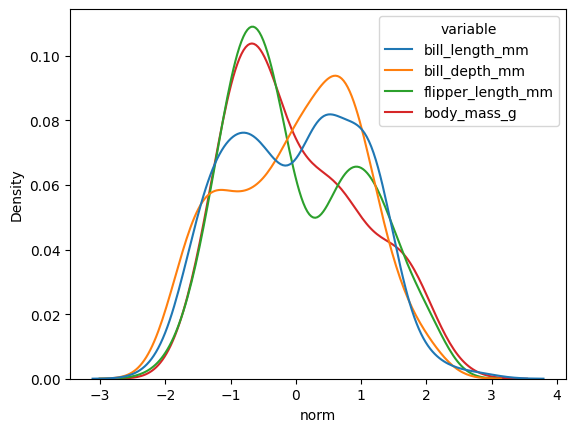

In [8]:
sns.kdeplot(p, x="norm", hue="variable")


Maybe, maybe not...

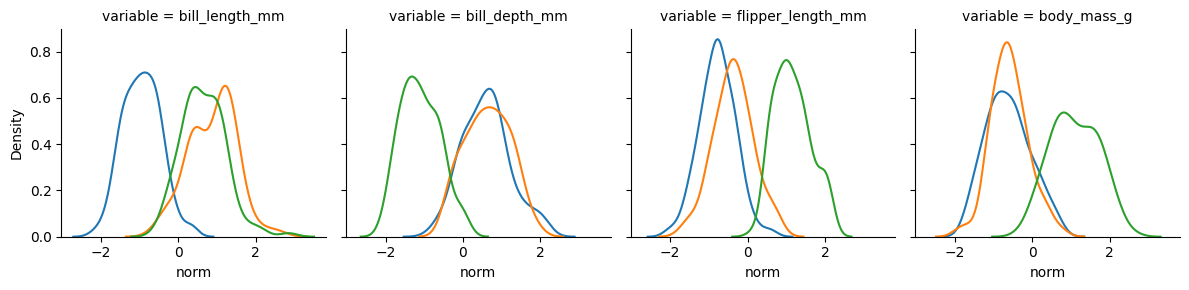

In [9]:
g = sns.FacetGrid(p, col="variable", hue="species")
g.map_dataframe(sns.kdeplot, x="norm")


Regardless of the type of distribution, we can still indicate how easy it will be to separate, for example, species.

## Testing distributions

Let's select, from the species "Adelie", the length of the flipper.


In [10]:
x = p[(p.variable == "flipper_length_mm") & (p.species == "Adelie")]["norm"]
x

666   -1.424608
667   -1.067867
668   -0.425733
669   -0.568429
670   -0.782474
         ...   
807   -1.210563
808   -0.425733
809   -0.568429
810   -0.996518
811    0.002357
Name: norm, Length: 146, dtype: float64

Now we can use the `Fitter` library to fit a distribution.
Let's test these four distrubutions:

In [11]:
from fitter import Fitter, get_common_distributions

d = ["uniform", "lognorm", "norm"]
d


['uniform', 'lognorm', 'norm']

Now we fit, and make a summary.

Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00, 61.97it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
norm,49.910073,320.832747,-146.746817,inf,0.069036,4.689626e-01
lognorm,49.926530,321.662503,-141.715078,inf,0.073489,3.906877e-01
uniform,59.279105,203.480674,-121.629849,inf,0.227830,3.835247e-07


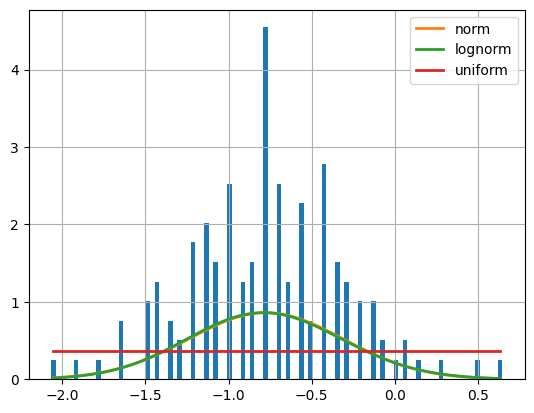

In [12]:
f = Fitter(x, distributions=d)
f.fit()
f.summary()


You can also get the parameters of the best fit:

In [13]:
f.get_best()


{'norm': {'loc': -0.7751433487558571, 'scale': 0.46372433617215086}}

Or from all of them:

In [14]:
f.fitted_param


{'norm': (-0.7751433487558571, 0.46372433617215086),
 'uniform': (-2.066741727700941, 2.7112326168699674),
 'lognorm': (0.022333063201468144, -21.5351502109227, 20.75483038064818)}

Fitter uses the pylab backend hardcoded. But we can hack the fitter object, by studying the [source code](https://fitter.readthedocs.io/en/latest/_modules/fitter/fitter.html#Fitter).

- There is a `self.get_best()` method that provides the parameters of the best fit.
- `self._data` provides us with the raw data for the historgram
- We can use `self.df_errors` to get a dataframe of the best fits. If we sort it, we can obtain the top 5 distributions.
- `plt.plot(f.x, f.fitted_pdf[name])` gives us the fitted pdf. `name` should be the name of the distribution.


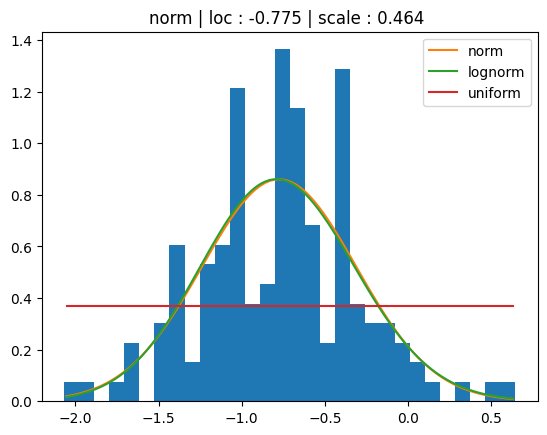

In [15]:
from src import visualization

fig, ax = plt.subplots()
visualization.custom_summary(f, ax)


This gives almost the same result, but we have more control over the details.

As you can see, the distributions are sort of close. But most probable, a normal distribution in this case.

Another, more informal way to check, is with a qq-plot (quantile-quantile plot) to visually test how the samples compare to the theoretical output for a normal distribution.

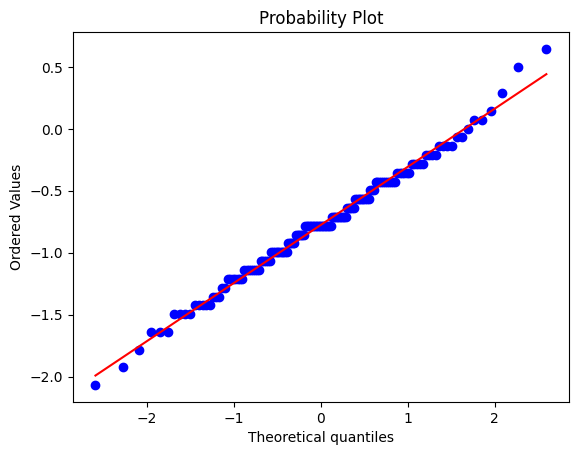

In [16]:
from scipy import stats

stats.probplot(x, dist="norm", plot=plt);


You can see there are still some outliers at the end. A perfect fit would line up along the red line.

Wrapping this:

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 58.14it/s]
/Users/raoulgrouls/code/datainterpretation/./src/visualization.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


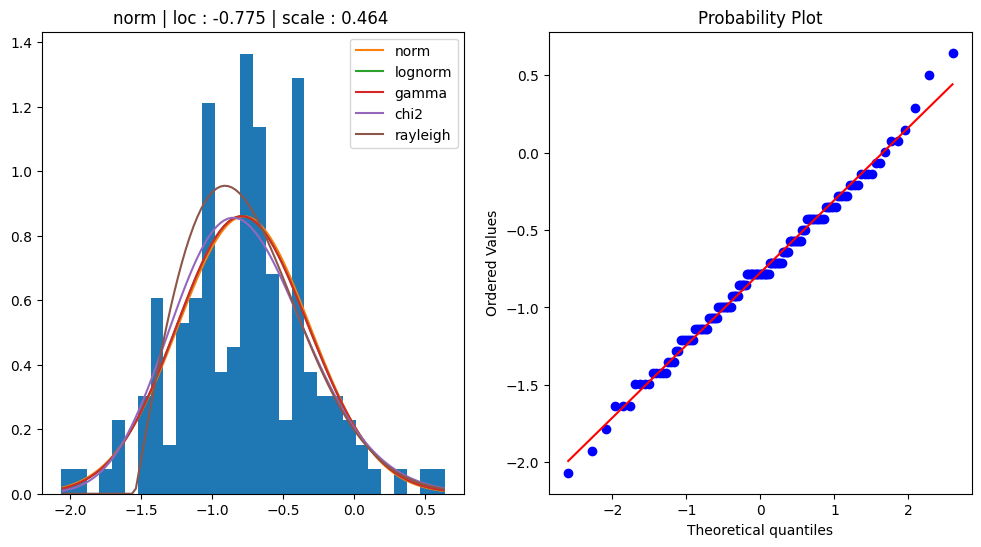

In [17]:
visualization.test_distribution(x)


That is confirmative for a normal distribution.
Now, let's try the same for all the variables

In [29]:
vars = list(p.variable.unique())
vars

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 59.83it/s]
/Users/raoulgrouls/code/datainterpretation/./src/visualization.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 85.00it/s]
/Users/raoulgrouls/code/datainterpretation/./src/visualization.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 60.85it/s]
/Users/raoulgrouls/code/datainterpretation/./src/visualization.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 77.53it/s]
/Users/raoulgrouls/code/datainte

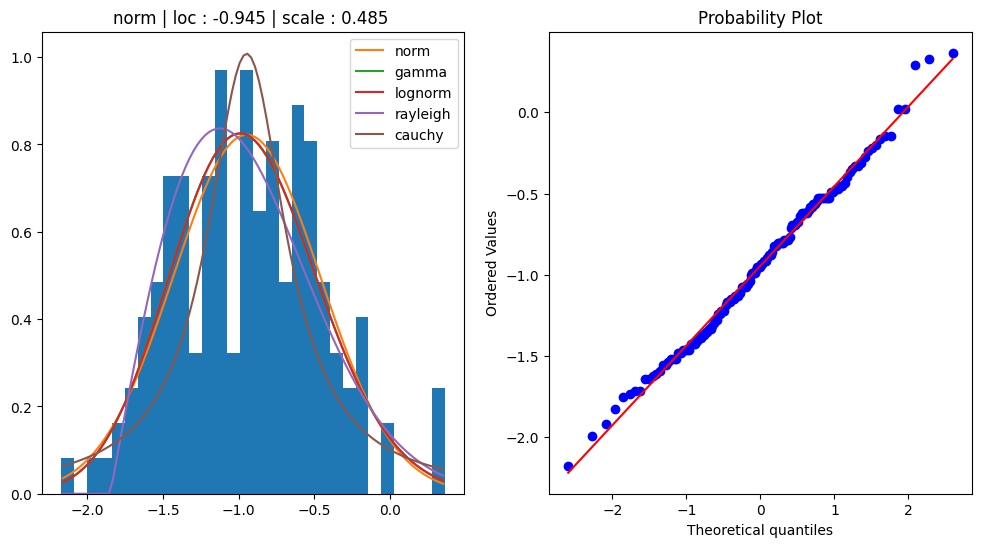

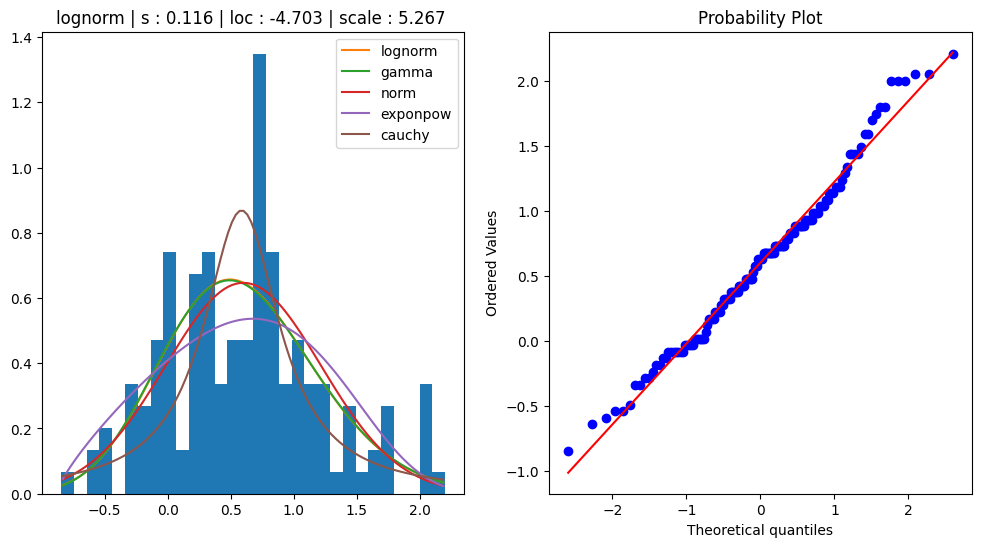

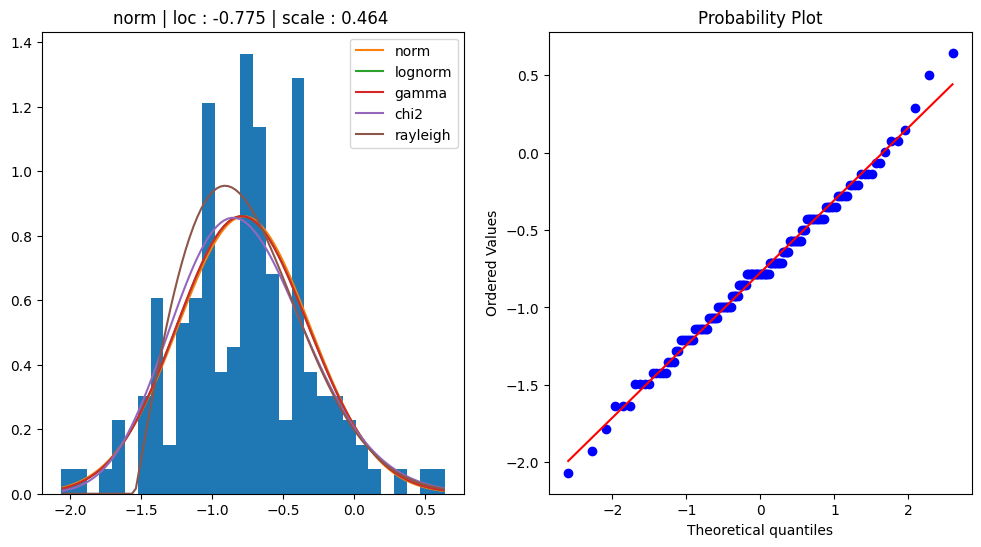

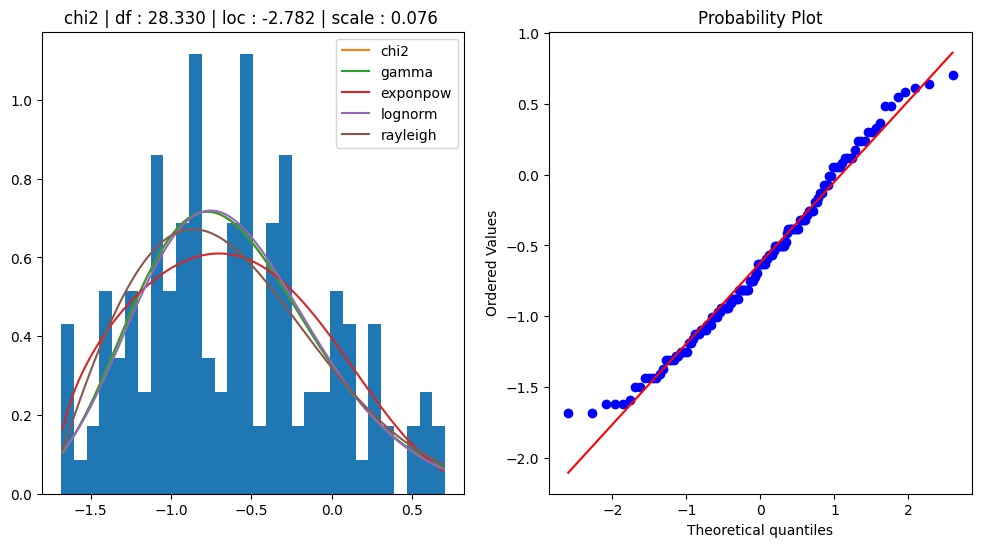

In [28]:
for var in vars:
    x = p[(p.variable == var) & (p.species == "Adelie")]["norm"]
    f = visualization.test_distribution(x)


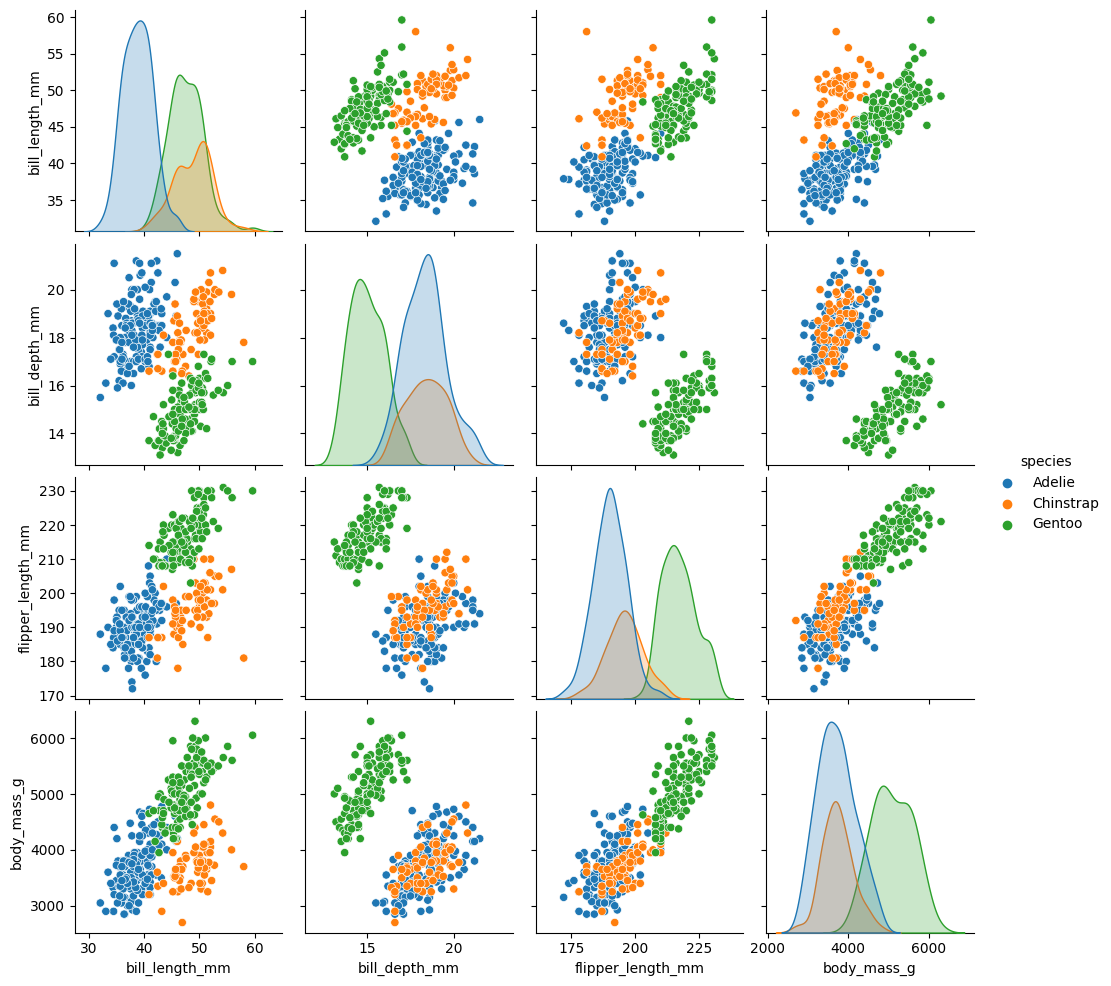

In [33]:
sns.pairplot(df, hue="species")

# Excercise
Now its your turn!

Try to figure out what's going on in the diamonds dataset.

In [4]:
df = sns.load_dataset("diamonds")

Some basic info about the dataset:

- price price in US dollars (\$326--\$18,823)
- carat weight of the diamond (0.2--5.01)
- cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color diamond colour, from J (worst) to D (best)
- clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- x length in mm (0--10.74)
- y width in mm (0--58.9)
- z depth in mm (0--31.8)
- depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table width of top of diamond relative to widest point (43--95)

In [5]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
